# Captcha Breaker

In [1]:
import os

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from imutils import paths
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from keras.optimizers import SGD
from keras.preprocessing.image import img_to_array

from model import LeNet
from break_captcha import break_captcha
from preprocess_images import preprocess

Using TensorFlow backend.


In [2]:
%load_ext autoreload
%autoreload 2

## Training

### Data

In [3]:
data = []
labels = []

imgpaths = [path for path in paths.list_images('annotated_digits')]

with tqdm(total=len(imgpaths)) as pbar:
    for imgpath in imgpaths:
        
        # Preprocess image
        img = cv2.imread(imgpath)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = preprocess(gray, 28, 28)
        gray = img_to_array(gray)
        data.append(gray)

        # Preprocess label
        label = imgpath.split(os.path.sep)[-2]
        labels.append(label)

        pbar.update(1)

100%|██████████| 2012/2012 [00:00<00:00, 2387.00it/s]


### Preprocessing

In [4]:
X_training, X_test, Y_training, Y_test = train_test_split(
    np.array(data, dtype=np.float32) / 255.0, 
    np.array(labels), 
    test_size=0.25, 
    random_state=42
)

label_binariser = LabelBinarizer().fit(Y_training)

Y_training = label_binariser.transform(Y_training)
Y_test = label_binariser.transform(Y_test)

### Model

In [5]:
model = LeNet.build(
    width=28, 
    height=28, 
    depth=1, 
    classes=9
)

model.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(lr=0.01),
    metrics=['accuracy']
)

history = model.fit(
    X_training,
    Y_training,
    validation_data=(X_test, Y_test),
    batch_size=32,
    epochs=15,
    verbose=1
)

Train on 1509 samples, validate on 503 samples
Epoch 1/15
1509/1509 [==============================] - 7s 5ms/step - loss: 2.1621 - acc: 0.2545 - val_loss: 2.1271 - val_acc: 0.5447
Epoch 2/15
1509/1509 [==============================] - 0s 124us/step - loss: 2.0775 - acc: 0.5288 - val_loss: 2.0282 - val_acc: 0.2445
Epoch 3/15
1509/1509 [==============================] - 0s 137us/step - loss: 1.9188 - acc: 0.6216 - val_loss: 1.8216 - val_acc: 0.2664
Epoch 4/15
1509/1509 [==============================] - 0s 121us/step - loss: 1.5304 - acc: 0.8250 - val_loss: 1.2627 - val_acc: 0.7634
Epoch 5/15
1509/1509 [==============================] - 0s 128us/step - loss: 0.7930 - acc: 0.9636 - val_loss: 0.7692 - val_acc: 0.5666
Epoch 6/15
1509/1509 [==============================] - 0s 142us/step - loss: 0.2753 - acc: 0.9848 - val_loss: 0.2135 - val_acc: 0.9960
Epoch 7/15
1509/1509 [==============================] - 0s 129us/step - loss: 0.1008 - acc: 1.0000 - val_loss: 0.0938 - val_acc: 0.9960
Epo

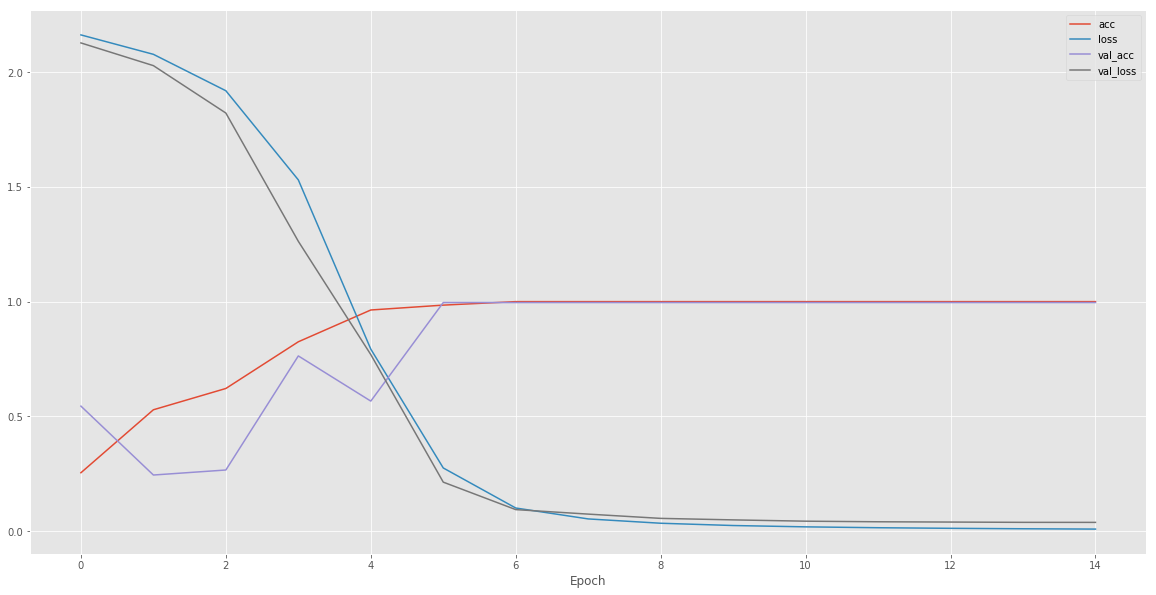

In [6]:
df = pd.DataFrame(history.history)

plt.style.use('ggplot')
df.plot(figsize=(20, 10))
plt.xlabel('Epoch');

## Test

In [7]:
predictions = model.predict(X_test, batch_size=32)

print(
    classification_report(
        Y_test.argmax(axis=1),
        predictions.argmax(axis=1),
        target_names=label_binariser.classes_
    )
)

             precision    recall  f1-score   support

          1       1.00      1.00      1.00        55
          2       1.00      1.00      1.00        61
          3       1.00      1.00      1.00        48
          4       1.00      0.99      0.99        69
          5       0.98      0.98      0.98        55
          6       0.99      1.00      0.99        75
          7       1.00      1.00      1.00        46
          8       1.00      1.00      1.00        54
          9       1.00      1.00      1.00        40

avg / total       1.00      1.00      1.00       503



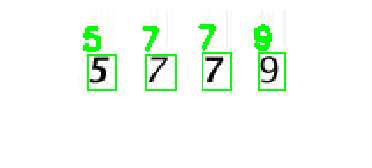

In [8]:
output, predictions = break_captcha('captchas/0999.jpg', model)

plt.imshow(output)
plt.axis('off');

In [9]:
model.save('model')